<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/experiments/Acc_Class_RNN_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_10s_3classes_npy"
train_set_folders = ["ps_1_dur_10_npy"                    
]

## Imports and Colab Mount

In [22]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os


from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Function Definitions

In [23]:
# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=raw_dataset_path, loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=raw_dataset_path, loader=numpy_loader,extensions='.npy',transform=data_transform)

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.squeeze().float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

Array shape is (27, 1, 13, 431)
13


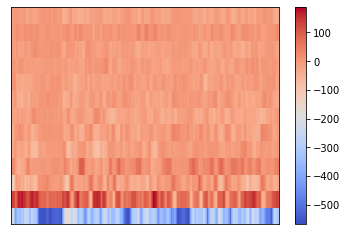

In [24]:
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
print(mfcc_bands)

## Base Arch

In [25]:
class AccClassRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, batch_size, name):
    super(AccClassRNN, self).__init__()
    self.ident = torch.eye(input_size)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.RNN(input_size, hidden_size, num_classes, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.batch_size = batch_size
    self.name = "AccClassRNN_" + name

  def forward(self, x):
    h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
    # Forward propagate the RNN
    out, _ = self.rnn(x, h0)
    # Pass the output of the last time step to the classifier
    output = self.fc(torch.max(out, dim=1)[0])
    return output

In [26]:
class AccClassLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, batch_size, name):
    super(AccClassLSTM, self).__init__()
    self.ident = torch.eye(input_size)
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.rnn = nn.LSTM(input_size, hidden_size, num_classes, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, hidden_size)
    self.fc2= nn.Linear(hidden_size, num_classes)
    self.relu = nn.ReLU()
    self.batch_size = batch_size
    self.name = "AccClassRNN_" + name

  def forward(self, x):
    # Set an initial hidden state
    h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
    c0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
    
    # Forward propagate the RNN
    out, _ = self.rnn(x, (h0,c0))
    
    # Pass the output of the last time step to the classifier
    output = self.relu(self.fc1(torch.max(out, dim=1)[0]))
    output = self.fc2(output)
    return output

## Train Func

In [27]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.squeeze().float().cuda().transpose(1,2)
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_rnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%25==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
          plot_graphs(iters, losses, [], train_acc, val_acc)
    
    plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

## Experiments

### Exp 1: Base

Using CUDA
Epoch:  0 Train Accuracy:  0.5600722673893406 Val Accuracy:  0.748792270531401 Progress:   1.33  % Time Elapsed:  49.45 s 
Epoch 0 Finished.  Time per Epoch:  49.45 s 
Epoch:  1 Train Accuracy:  0.5727190605239386 Val Accuracy:  0.7407407407407407 Progress:   2.67  % Time Elapsed:  99.66 s 
Epoch 1 Finished.  Time per Epoch:  49.83 s 
Epoch:  2 Train Accuracy:  0.5727190605239386 Val Accuracy:  0.7439613526570048 Progress:   4.00  % Time Elapsed:  148.01 s 
Epoch 2 Finished.  Time per Epoch:  49.34 s 
Epoch:  3 Train Accuracy:  0.5727190605239386 Val Accuracy:  0.7407407407407407 Progress:   5.33  % Time Elapsed:  195.56 s 
Epoch 3 Finished.  Time per Epoch:  48.89 s 
Epoch:  4 Train Accuracy:  0.5835591689250226 Val Accuracy:  0.7439613526570048 Progress:   6.67  % Time Elapsed:  242.92 s 
Epoch 4 Finished.  Time per Epoch:  48.58 s 
Epoch:  5 Train Accuracy:  0.5790424570912376 Val Accuracy:  0.7423510466988728 Progress:   8.00  % Time Elapsed:  290.13 s 
Epoch 5 Finished.

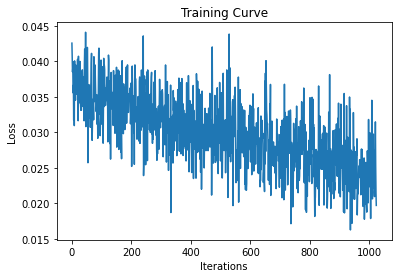

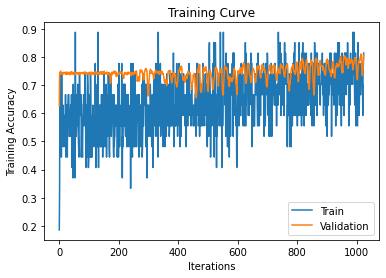

Epoch:  25 Train Accuracy:  0.7127371273712737 Val Accuracy:  0.7971014492753623 Progress:  34.67  % Time Elapsed:  1209.49 s 
Epoch 25 Finished.  Time per Epoch:  46.52 s 
Epoch:  26 Train Accuracy:  0.7208672086720868 Val Accuracy:  0.784219001610306 Progress:  36.00  % Time Elapsed:  1254.78 s 
Epoch 26 Finished.  Time per Epoch:  46.47 s 
Epoch:  27 Train Accuracy:  0.7118337850045167 Val Accuracy:  0.7230273752012882 Progress:  37.33  % Time Elapsed:  1300.72 s 
Epoch 27 Finished.  Time per Epoch:  46.45 s 
Epoch:  28 Train Accuracy:  0.7416440831074977 Val Accuracy:  0.7874396135265701 Progress:  38.67  % Time Elapsed:  1346.34 s 
Epoch 28 Finished.  Time per Epoch:  46.43 s 
Epoch:  29 Train Accuracy:  0.7082204155374887 Val Accuracy:  0.7310789049919485 Progress:  40.00  % Time Elapsed:  1392.19 s 
Epoch 29 Finished.  Time per Epoch:  46.41 s 
Epoch:  30 Train Accuracy:  0.7588075880758808 Val Accuracy:  0.8341384863123994 Progress:  41.33  % Time Elapsed:  1438.39 s 
Epoch 30 

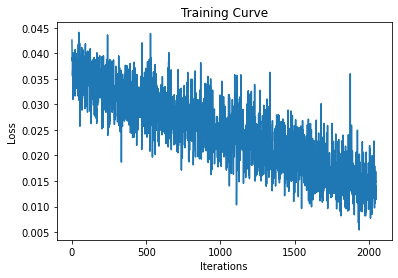

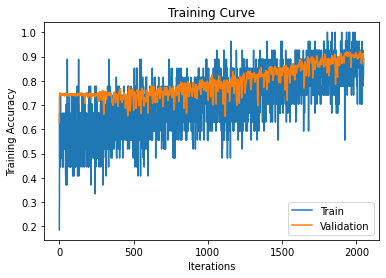

Epoch:  50 Train Accuracy:  0.8545618789521229 Val Accuracy:  0.8904991948470209 Progress:  68.00  % Time Elapsed:  2349.14 s 
Epoch 50 Finished.  Time per Epoch:  46.06 s 
Epoch:  51 Train Accuracy:  0.8789521228545619 Val Accuracy:  0.9146537842190016 Progress:  69.33  % Time Elapsed:  2394.10 s 
Epoch 51 Finished.  Time per Epoch:  46.04 s 
Epoch:  52 Train Accuracy:  0.8735320686540199 Val Accuracy:  0.8808373590982287 Progress:  70.67  % Time Elapsed:  2439.02 s 
Epoch 52 Finished.  Time per Epoch:  46.02 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 75
learning_rate = 0.001
hidden_size = 40
num_classes = 3
name = "base_RNN"
mfcc_bands = 13
acc_net = AccClassRNN(13, hidden_size, num_classes , batch_size, name)
train_net(acc_net, batch_size = 27, learning_rate = 0.001, num_epochs = num_epochs)
#train_rnn_network(acc_net, train_data, val_data, batch_size = 27, learning_rate = learning_rate, num_epochs = num_epochs)

#lstm = LSTM(mfcc_bands, hidden_size, num_classes)
#train_net(lstm, batch_size = 27, learning_rate = 0.001, num_epochs = 30)